In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import Audio

%matplotlib inline

## Creating mixtures

In [41]:
numMixtures = 2
numSources = 2
dur = 5 # duration of the signals in seconds 

fs1, source1 = wav.read('/Users/yu-jehliu/OneDrive/UIUC/ICA/SoundSources/news.wav')
fs2, source2 = wav.read('/Users/yu-jehliu/OneDrive/UIUC/ICA/SoundSources/mozart_vl_44k.wav')
s = np.asarray(np.vstack((source1[:dur*fs1], source2[:dur*fs2])))
A = np.random.uniform(size=(numMixtures, numSources))
x = (A @ s)

/Users/yu-jehliu/anaconda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


First Mixture

In [42]:
Audio(x[0], rate=fs1)

Second Mixture

In [43]:
Audio(x[1], rate=fs1)


## Preprocessing: Mean Subtraction

In [44]:
for i in range(numMixtures):
    mu = np.mean(x[i])
    x[i] -= mu

## Preprocessing: Second Order Statistics

In [72]:
# Setting the cavariance to be 0, variance to be 1
cov = (x[:,0].reshape(2,1) @ x[:,0].reshape(1,2)) / len(x[0])

for i in range(1,len(x[0])):
    cov += (x[:,i].reshape(2,1) @ x[:,i].reshape(1,2)) / len(x[0])

In [82]:
eigVal, V = np.linalg.eigh(cov)

inv_eigVal = np.zeros(eigVal.shape)
for i in range(len(eigVal)):
    inv_eigVal[i] = 1.0/eigVal[i]
    
D_negHalf = np.diag(np.sqrt(inv_eigVal))
x_tilde = V @ D_negHalf @ V.T @ x

##### Verify that $E[\tilde{x} \tilde{x}^T] = I$

In [85]:
covtilte = (x_tilde[:,0].reshape(2,1) @ x_tilde[:,0].reshape(1,2)) / len(x_tilde[0])

for i in range(1,len(x[0])):
    covtilte += (x_tilde[:,i].reshape(2,1) @ x_tilde[:,i].reshape(1,2)) / len(x_tilde[0])
print(covtilte)

[[  1.00000000e+00  -2.64725123e-13]
 [ -2.64725123e-13   1.00000000e+00]]


## Visualize the distribution of the mixture data $\tilde{x}$

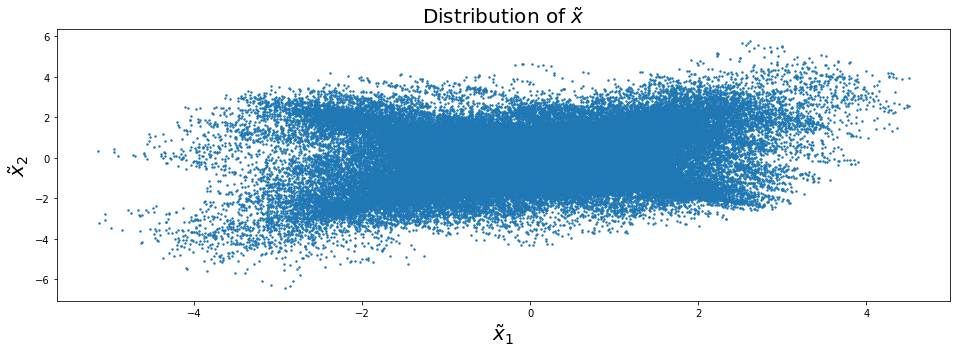

In [99]:
plt.figure(figsize=(16,5))
plt.scatter(x_tilde[0], x_tilde[1], s= 2)
plt.title(r'Distribution of $\tilde{x}$', fontsize=20)
plt.xlabel(r'$\tilde{x}_1$', fontsize=20)
plt.ylabel(r'$\tilde{x}_2$', fontsize=20)

# ICA: Gradient Ascent

#### Suppose that we have a unmixing matrix $W$, $n$ mixtures $x_i$ where $i=1,2,\cdots,n$. The components extracted will be $U=Wx$, where $U=\{u_1,u_2,\cdots,u_n\}$. Now because we would want to minimize the mutual information -> maximize the joint entropy $H(U)$ , and also we know that $H(U)=H(x)+E[\sum^{n}_{i=1}lnp_s(u_i)]+ln\|W\|=H(x)+E[\sum^{n}_{i=1}lng'(u_i)]+ln\|W\|$  where $p_s(u_i)$ is the pdf of $u_i$ $g'(u_i)$ is the cdf of $u_i$. Since the term $H(x)$ is dependent of $W$, our objective function becomes
#### $$\max_{W}E[\sum^{n}_{i=1}lng'(u_i)]+ln\|W\|$$

#### The optimized $\hat{W}$ will be found using gradient ascent.

In [101]:
#First initialize the unmixing matrix W
W = np.identity(numMixtures)

#Choose a learning rate for the gradient ascent algorithm
eta = 0.1

#### Now after taking partial derivative of the objective function with respect to $W$, we can write the Jacobian as
#### $$\nabla h=W^{-T}-\frac{2}{N}\sum^{N}_{k=1}tanh(u^k)(x^k)^T$$
#### where $u^k$ and $x^k$ are the values corresponding to the time instance $k$

In [114]:
# for loop to update the unmixing matrix W
from tqdm import tqdm
NumIter = 100 # number of iterations

for i in tqdm(range(NumIter)):
    u = W @ x_tilde
    W_invT = (np.linalg.inv(W)).T
    
    for j in range(len(x_tilde[0])):
        W_invT -= (2./len(x_tilde[0])) * (np.tanh(u[:,j]).reshape(2,1) @ (x_tilde[:,j].reshape(1,2))) 
    
    W = W + eta * W_invT

100%|██████████| 100/100 [05:51<00:00,  3.42s/it]


## Visualize the direction of computed using the ICA Gradient Ascent method

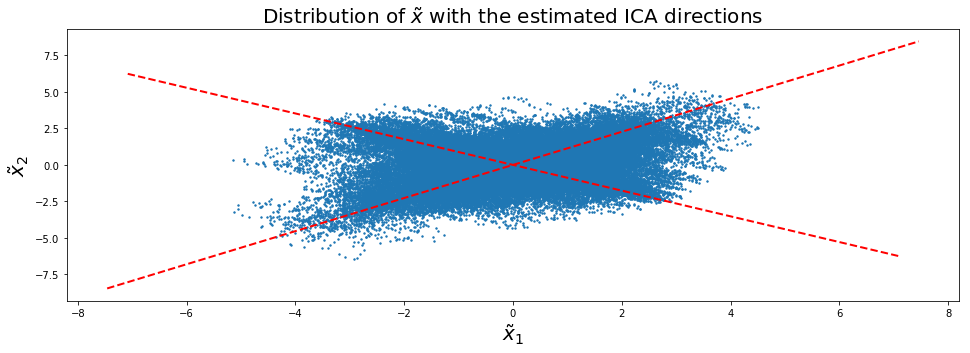

In [117]:
plt.figure(figsize=(16,5))
plt.scatter(x_tilde[0], x_tilde[1], s= 2)
plt.plot([-W[0,0]*10, W[0,0]*10],[-W[0,1]*10, W[0,1]*10], '--r',linewidth=2)
plt.plot([-W[1,0]*10, W[1,0]*10],[-W[1,1]*10, W[1,1]*10], '--r',linewidth=2)
plt.title(r'Distribution of $\tilde{x}$ with the estimated ICA directions', fontsize=20)
plt.xlabel(r'$\tilde{x}_1$', fontsize=20)
plt.ylabel(r'$\tilde{x}_2$', fontsize=20)

## Obtain the final unmixed estimates 

In [119]:
final_unmixed = W @ x_tilde
Audio(final_unmixed[0], rate=fs1)

In [120]:
Audio(final_unmixed[1], rate=fs1)